<h1>Problem Set 2</h1>
<p> This Jupyter Notebook contains my solutions to the second problem set in CS598PS. All three problems can be found here, as well as markup explaining all cells and answering all questions asked in the assignment</p>

In [1]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.sparse as scilin
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import math
import numpy.linalg as la
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.neighbors import kneighbors_graph
from sklearn.utils.graph import graph_shortest_path

<h2> Important Functions </h2>
<p>
This section contains implementations for various key functions that I will use to solve the problems. The first section contains functions more related to problem 1 and 2, ie linear dimensionality reduction (PCA, ICA, NMF) and spectogram generation. The second section contains functions more related to problem 3, ie non-linear dimensionality reduction and manifold learning (MDS and ISOMAP)
</p>


<h3>Section 1:</h3>
<h4>Spectogram</h4>
<p>In problem 1, we are asked to look at audio data. For that, we need to caluclate the spectogram of the audiofile in order to feed our spectogram data into the various dimensionality reduction techniques we have learned (PCA, ICA and NMF). </p>
<p>In this implementation, I construct my DFT matrix using Hamming weights and N, which is the number of points I want to make my DFT. I then use a simple loop to slide that DFT matrix across my data given the hop size and compute the matrix multiplication between the DFT matrix and the current chunk I have sliden on. This can be thought of as seeing how prominent certain sinusoids are in the chunks of our data. </p>
<h5>Inputs:</h5>
<ul>
    <li>
        signal: Our audio file
    </li>
    <li>
        N: the window size of our DFT matrix, how many samples we should consider whenever we slide our matrix.
    </li>
    <li>
        hs: the hop size. How much we should move our matrix by. 
    </li> 
    <li>
        Say we are given a signal of length 20,480. We are asked to find the spectogram of this signal using N = 1024 and hs
        512. From this, we can see that we can find how many samples our data will have using the following formula: (length-hs)/(N-hs). In the case our division does not result in a whole number, we can floor the result, or do some 0-padding. I went with flooring here because it is eaiser.
    </li>
</ul>
<h5>Outputs:</h5>
<ul>
    <li>S: the resulting spectogram of our data, sampled at the rate we specified. </li>   
</ul>

In [2]:
def spectrogram(signal, N = 1024, hs = 512):
    # compute Hamming weights
    alpha   = 0.54
    beta    = 1 - alpha
    pi2     = 2.0*math.pi
    c       = pi2/(N-1)
    w       = alpha - beta * np.cos(c*np.arange(0,N,1))

    # compute DFT matrix
    p = np.arange(0,N,1).reshape(N,1)
    F = np.exp( -(pi2/N)*np.matmul(p,p.T)*1j )  / np.sqrt(N)

    # compute resulting local matrix
    D = np.multiply(F,w)
    plt.imshow(np.abs(D))

    # Compute number of samples in spectrogram
    (length,c)     = signal.shape
    num_samples = math.floor((length - hs)/(N - hs))

    # initialize output S
    S = np.zeros((N,num_samples),dtype=type(F[0,0]))

    # loop through and construct S
    for i in range(0,num_samples):
        S[:N, i] = np.matmul(D,signal[i*hs:(i*hs+N),0])

    # return the output spectrogram
    return S[:int(N/2),:]

<h4>Principal Component Analysis (PCA)</h4>
<p>PCA has many applications, including dimensionality reduction and decorelating our data. What PCA does from an intuitive perspective is to find a vector that when our data is projected on it, the variance is maximized. Next, it will give us the vector with the second highest projection variance, assuming that the two vetors are orthoganal. This continues until it has found the number of components we desire. More concretely, given our data, we can find these vectors by running an eigen decomposition on the covariance of our data. The eigen vectors are our new basis. Since we are running an eigen decomposition, we can rank the resulting eigen vectors using their accompoinied eigen values, which allows us to drop dimensions.</p>
<p>There are many ways to compute this eigen decomposition. Here, I chose SVD because I am already familiar with it. Numpy's SVD function outputs U, s and Vt. U is a matrix containing the eigen vectors in its columns, ranked by their eigen values. s is a vector containing our eigen values. I like to think of Vt as a matrix that defines how we need to combine our principal components to reconstruct our data. The principal components can be found by multiplying the resulting U with another matrix which contains the inverse sqrt of the eigen values along the diagnol. To drop components, we use slicing. 
</p>
<h5>Inputs:</h5>
<ul>
    <li>centeredCovariance: this is the centered covariance of the data matrix. </li>
    <li>numOfComponents: how many components we want to keep.</li>
</ul>
<h5>Outputs:</h5>
<ul>
    <li>Wp: principal components which are found by multiplying the resulting U with another matrix which contains the inverse sqrt of the eigen values along the diagnol</li>   
</ul>

In [3]:
def pca(centeredCovariance, numOfComponents):
    # use SVD to get eigen decomposition of our centered covariance
    [U,s,Vt] = la.svd(centeredCovariance)
    
    # slicing to drop dimensions
    Uk = U[:,:numOfComponents]
    sk = s[:numOfComponents]
    
    # calculate our principal components
    Wp = np.diag(sk**-0.5) @ Uk.T
    return Wp

<h4>Independent Component Analysis(ICA)</h4>
<p>
    ICA works to decompose our data into independent, non-Gaussian signals. The most common example is the cocktail party problem, where we are trying to seperate people talking at a cocktail party. Because PCA only decorelates our data, and does not give us independence, we can run ICA on our PCA projection to 1) drop the dimensions (PCA) and 2) achieve indepnece (ICA). More formally, say we are given Zp which is the projection of our data onto the principal components (Zp = data @ principal components). This data is considered "whitened", meaning it's covariance is 0 along all non-diagnol elements (uncorelated). ICA will take this to the next level by giving us a matrix Wi to decompose our input into a new matrix y as follows: y = Wi @ Zp such that all components of y are indepented: P(yi, yj) = P(yi)P(yj) for all i's and j's. 
</p>
<p>
    Again, there are many methods for running ICA on data. Here, I implement a gradient descent algortihm which works to minimize the mutal information between the components of y. I initially set Wi to be the identity matrix. The update rule is proportional to the following: (I - f(y) @ y.T) @ Wi. I also update y for every step of the optimization. I optimize until the gradient stops changing based on some threshold.
</p>
<h5>Inputs:</h5>
<ul>
    <li>Zp: this is the centered covariance of the data matrix. </li>
    <li>thresh: how many components we want to keep.</li>
    <li>alpha: how many components we want to keep.</li>
</ul>
<h5>Outputs:</h5>
<ul>
    <li>Wi: our analysis features. If we project our whitened data onto this, we will achieve independence.</li>   
</ul>

In [4]:
def ICA(Wi, thresh=50, alpha=1e-5):
    k, n = np.shape(Zp)
    
    # the initial guess for Wi
    Wi = np.eye(k)
    
    # our decomposition
    y = Wi @ Zp
    
    # some helper variables
    M, N = np.shape(y)
    mag_dW = thresh *100
    i = 0
    
    # optimization loop
    while (mag_dW > thresh):
        # updating Wi, y and calculating the norm of our 
        # gradient to see if it changes from step to step
        # if it does NOT change, we are done optimizing. n
        gradW = ((N*np.eye(k) - 2 * np.tanh(y) @ y.T)) @ Wi
        newW = Wi + alpha * gradW
        mag_dW = np.linalg.norm(gradW)
        Wi = newW
        y = Wi @ Zp
        if(i%700 == 0):
            print(mag_dW)
        i+=1
    return Wi

<h4>Non-negative Matrix Factorization (NMF)</h4>
<p>While PCA and ICA do a great job of doing what we want from a mathematical standpoint, we often lose the ability to explain our results when our data contains only positive values. PCA and ICA will give us features that have desirable properties when our data is projected with them, but our features can have negative values. The example given in class about the Iris data set is useful to keep in mind. If we do PCA and ICA on this data set, we will get components that have negative values for variables such as sepal length and width, which obviously is not very interpretable (can't have a negative length). NMF gives us features that are all positive valued. More formally, NMF decomposes our matrix into Wnmf and Hnmf. Wnmf are the features and Hnmf are how we mix them to reconstruct our data. </p>
<p>Here I implement NMF using the multiplicative rules in an iterative algorithm. I initailze some random Wnmf and Hnmf and optimize until my reconstruction is close to the original data based on a threshold. The mutiplicative rules were found on slide 44 of the ICA and NMF lecture slides and https://en.wikipedia.org/wiki/Non-negative_matrix_factorization </p>
<p></p>
<h5>Inputs:</h5>
<ul>
    <li>X: our data </li>
    <li>tol: how similar our reconstruction needs to be to our input data to consider the algorithm as converged</li>
    <li>maxSteps: how many steps the algorithm should run, irregardless of covergence</li>
    <li>numOfComponents: how many components we want to keep.</li>
</ul>
<h5>Outputs:</h5>
<ul>
    <li>Wnmf: our analysis features, with all positive values</li>
    <li>Hnmf: how we combine our analysis features to reconstruct the data</li>
</ul>

In [5]:
def nmf(X, tol=.001, maxSteps=5000, numOfComponents=3):

    # Random initialization of Wnmf and Hnmf
    Wnmf = np.random.rand(X.shape[0], numOfComponents)
    Hnmf = np.random.rand(numOfComponents, X.shape[1])

    # Our error which updates every step based on our original X and our reconstruction that step
    error = 1e5

    # A very small number to ensure matrices are strictly positive
    eps = 1e-7
    
    # optimzation loop, break either when we have reached maxSteps
    for i in range(maxSteps):
      
        # Multiplicative update steps
        Hnmf = Hnmf * ((Wnmf.T.dot(X) + eps) / (Wnmf.T.dot(Wnmf).dot(Hnmf) + eps))
        Wnmf = Wnmf * ((X.dot(Hnmf.T) + eps) / (Wnmf.dot(Hnmf.dot(Hnmf.T)) + eps))

        # Frobenius distance between WH and X
        newError = np.linalg.norm(X-Wnmf.dot(Hnmf), 'fro')
        if(i%700 == 0):
            print(abs(error - newError))
        # Check for convergence
        if abs(error - newError) < tol:
            break

        error = newError
        
    return Wnmf,Hnmf

<h3>Section 2:</h3>
<h4>Multidimensional Scaling (MDS)</h4>
<p>
MDS is a way to see how similar or different individual cases of a dataset are. For this problem, we explore the similarities and differences of the digit 6 from the dataset. MDS expects us to provide it not the raw data, but the global distances between the different data points as a matrix (we can call this the distance matrix). It then centers the distance matrix and runs eigen decomposition. We ususally reduce the dimensions to 2 or 3 so we can visualize the manifold by plotting it. 
</p>
<p>
Clasical MDS uses global distances caluclated with the euclidian distance formula. However, it can easily be extended to use other types of distances and distance metrics. ISOMAP is one of these extensions.
</p>
<h5>Inputs:</h5>
<ul>
    <li>distanceMatrix: our distance matrix, can be global or local distances. For ISOMAP, pass the local distances </li>
    <li>numOfComponents: how many components we want to keep. Standard value is 2 for plotting purposes</li>
</ul>
<h5>Outputs:</h5>
<ul>
    <li>Uk: the MDS features</li>
</ul>

In [6]:
def mds(distanceMatrix, numberOfComponents=2):
    numberOfSamples = distanceMatrix.shape[0]

    # CENTER THE DISTANCE MATRIX:
    # Mean for each row and column:
    meanRows = np.sum(distanceMatrix, axis=0) / numberOfSamples
    meanCols = (np.sum(distanceMatrix, axis=1)/numberOfSamples)[:, np.newaxis]
    # Mean across all rows (entire matrix):
    meanAll = meanRows.sum() / numberOfSamples
    # Centering:
    distanceMatrix -= meanRows
    distanceMatrix -= meanCols
    distanceMatrix += meanAll
  
    # EIGEN DECOMPOSITION USING SVD ON THE CENTERED DISTANCE MATRIX:
    [U,s,Vt] = la.svd(distanceMatrix)
    Uk = U[:,:numberOfComponents]
    return Uk

<h4>ISOMAP:</h4>
<p>ISOMAP is basically MDS but looking at local distances instead of gloabl distances. It allows us to perform dimensionality reduction while maintaining the local distances as best as we can. Here is the basic flow of the algorithm:</p>
<ol>
    <li>Determine the K nearest neighbors for each point and construct neighborhood graph (kneighbors_graph) </li>
    <li>Compute the shortest path between all nodes in the neighborhood graph (graph_shortest_path)</li>
    <li>Run MDS on the shortest path matrix found in step 2</li>
</ol>
<h5>Inputs:</h5>
<ul>
    <li>data: our data </li>
    <li>numOfComponents: how many components we want to keep when we run MDS.</li>
    <li>numOfNeighbors: how many neighbors do we want to look at to construct the neighborhood graph.</li>
</ul>
<h5>Outputs:</h5>
<ul>
    <li>The MDS output when ran on the graph containing the shortest distances based on the numberOfNeighbors</li>
</ul>

In [7]:
def isomap(data, numberOfComponents=2, numberOfNeighbors=6):
    kNGraph = kneighbors_graph(X=data, n_neighbors=numberOfNeighbors, mode='distance')
    distances = graph_shortest_path(kNGraph, directed=False)
    distances = -0.5 * (distances ** 2)
    return mds(distances, numberOfComponents)

<h2>Problems</h2>
<p>Here you will find code, figures and explanations for the 3 problems.</p>

<h3>Problem 1: An Audio Fetures Project</h3>

In [8]:
# define the number of features you want
num_features = 3

# load the sound file and get into proper shape
(freq,signal) = wav.read('../data/vl1.wav')
N = signal.shape[0]
signal = signal.reshape(N,1)

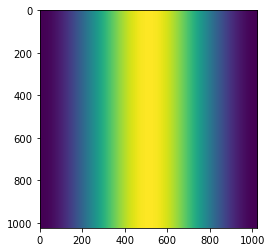

In [9]:
# Spectogram caluclations, I also plot it. This looks like a good DFT matrix to me. 
window_size = 1024
hop_size = int(window_size/4) # this should get me the 3/4 overlap
S = spectrogram(signal,N=window_size,hs=hop_size)

# find the magnitude of the spectrogram matrix
(r,c) = S.shape
Sn = np.abs(S)

# compute mean of spectrogram data
mu_s = (Sn @ np.ones((c,1))/c)

# subtract mean from data
Sn_d = Sn - mu_s

In [10]:
# run PCA on centered spectogram magnitude and calculate Zp
Wp = pca(Sn_d,num_features)
Zp = Wp @ Sn_d

In [11]:
# run ICA on Zp and multiply that with Zp to get the overal Wi transformation
Wi = ICA(Zp) @ Zp
# we need to plot the pinv of this Wi
Wi_inv = np.linalg.pinv(Wi)

13265.79797557223


In [12]:
# run NMF on the non centered data to get out our Wnmf and Hnmf
Wnmf, Hnmf = nmf(Sn)

311325.35175695573
0.0027110241062473506


<h3>Figures for problem 1:</h3>
<p>The next section contains the figures for the PCA, ICA and NMF features. I explain them here.</p>
<h5>PCA Features:</h5>
<p>
PCA gives me components that can contain both positive and negative values. Each of these components are decorelated, but not independent, therefore, I do not think we can say that the components represent each insturment. 
</p>
<h5>ICA Features:</h5>
<p>
ICA gives me components that can contain both positive and negative values. Each of these components are independent. These features can be thought of as the frequency characteristics of the insturments making up the signal. Because we can have negative values, it is hard to actually interpret the results as anything more, but they do do a better job of seperating the features than PCA because of the independence ICA aims to achieve. 
</p>
<h5>NMF Features:</h5>
<p>NMF gives me components that contain only positive values. The features are the frequency characteristics of the instruments and because the values are more positive, it gives the more interpretable results in this case. From what I can tell, it looks like the third component (Wnmf3) is the drums as it's energy is distributed across many frequencies. The other two components might be the synthesizer sounding instruments playing at different notes as they have more defined frequency distribtion.</p>

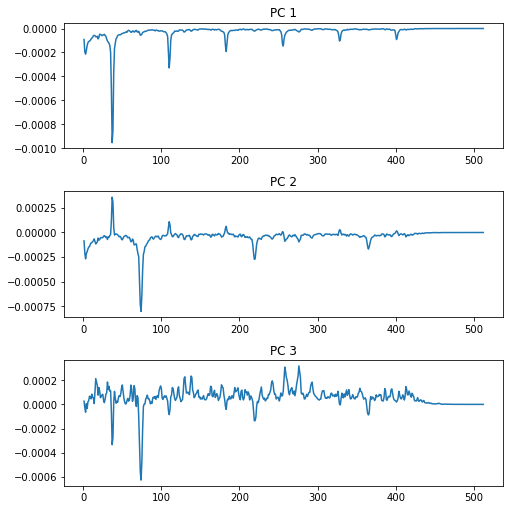

In [13]:
# Plotting the principal components
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot(ind, Wp.T[:, k])
    ax1[k].set_title('PC '+str(k+1))
fig.set_figheight(7)
fig.set_figwidth(7)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

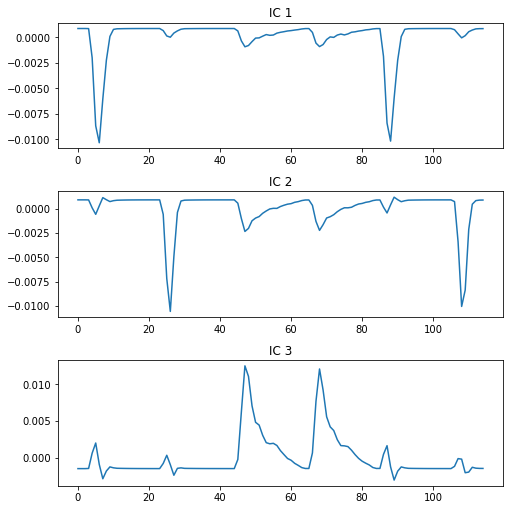

In [14]:
# Plotting the independent components
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( Wi_inv[:, k])
    ax1[k].set_title('IC '+str(k+1))
fig.set_figheight(7)
fig.set_figwidth(7) 
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

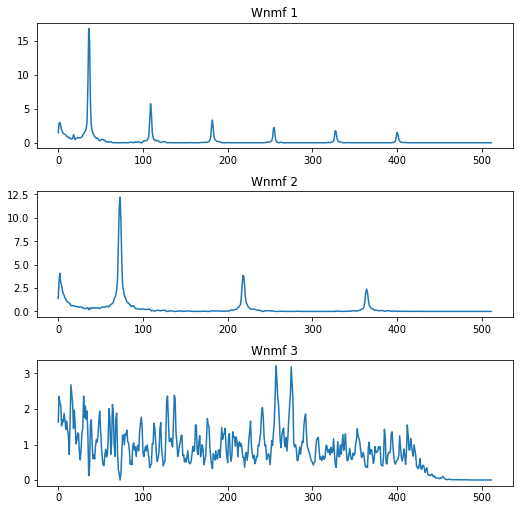

In [15]:
# Plotting the nmf features
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( Wnmf[:, k])
    ax1[k].set_title('Wnmf '+str(k+1))
fig.set_figheight(7)
fig.set_figwidth(7)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

<h3>Problem 2: Handwritten Digit Features</h3>

In [16]:
# load data and set some helper variables
X = np.load("../Data/digits-labels.npz")["d"]
m, n = X.shape # m is number of features and n is number of images
k = 36 # k is the number of pc's we want

print(f"We have {n} images of vectorized length {m}. We are trying to reduce these images to be {k}-dimensional.")

We have 10000 images of vectorized length 784. We are trying to reduce these images to be 36-dimensional.


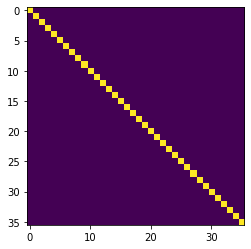

In [17]:
# center data
mu_image = (1/n) * (X @ np.ones((n,1)))
X_zeroed = X - mu_image

# get covariance of X_zeroed
cov_X_zeroed = (1/(n-1)) * (X_zeroed @ X_zeroed.T)

# run PCA on this covariance to get Wp
Wp = pca(cov_X_zeroed, k)
Wp_inv = np.linalg.pinv(Wp)

# calculate the projection of our data onto the components
Zp = Wp@ X_zeroed

# Plotting the covariance of our Zp to prove decorelation
plt.imshow(Zp@Zp.T)

In [18]:
# do ica on Zp to get Wi
Wi = ICA(Zp, thresh=50, alpha=1e-5)

# calculate the overall ICA transform (combine it with PCA)
WI = Wi @ Wp
WI_inv = np.linalg.pinv(WI)

13411.52080789124
505.64971792565086
231.36926687848643
94.71392244150583
62.29301494913892


In [19]:
# Do NMF on non centered data
Wnmf, Hnmf = nmf(X, tol=.1, maxSteps=5000, numOfComponents=36)

99291.93080156938


<h3>Figures for Problem 2:</h3>
<p>The next section contains the figures for the PCA, ICA and NMF features for the digits. I explain them here.</p>
<h5>PCA Features:</h5>
<p>
PCA gives me components that can contain both positive and negative values. Each of these components are decorelated, but not independent. The first few pc's kind of represent digits, however as we go down, the principal components really aren't that nice looking. 
</p>
<h5>ICA Features:</h5>
<p>
ICA gives me components that can contain both positive and negative values. Each of these components are independent. These components are much more intepretable than the pc's. They all appear to look like actual digits. This is because ICA goes one step further to PCA and gives me independent components
</p>
<h5>NMF Features:</h5>
<p>NMF gives me components that contain only positive values. Instead of giving me the whole digit as a feature, these features look like the individual components that make up any possible digit. They look very similar to features that a conv net might learn (edges/curves). ICA might be more intepretable as the output looks like digits, however, as a human, I can look at the output of NMF and construct any digit by using just the images that NMF gives me more like a puzzle.</p>

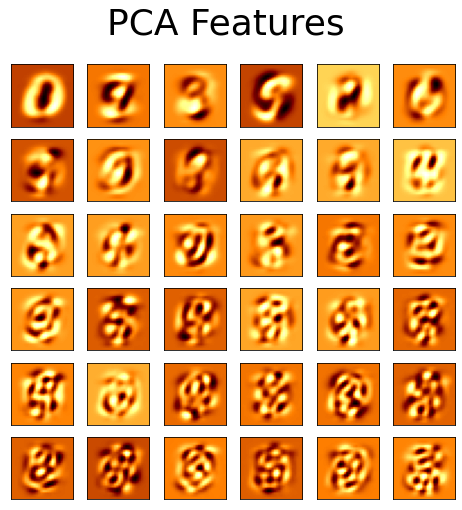

In [20]:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(Wp.T[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)
title = fig.suptitle('PCA Features', fontsize=36)

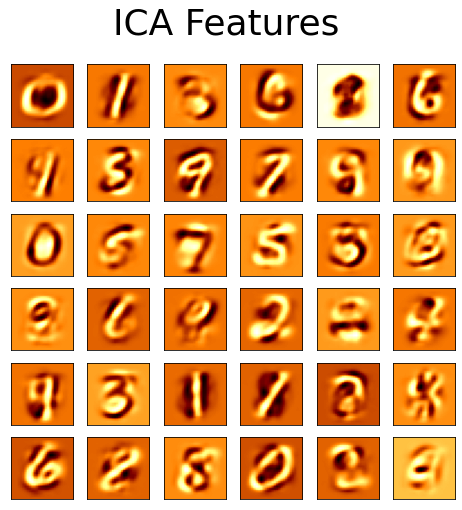

In [21]:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(WI_inv[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)
title = fig.suptitle('ICA Features', fontsize=36)

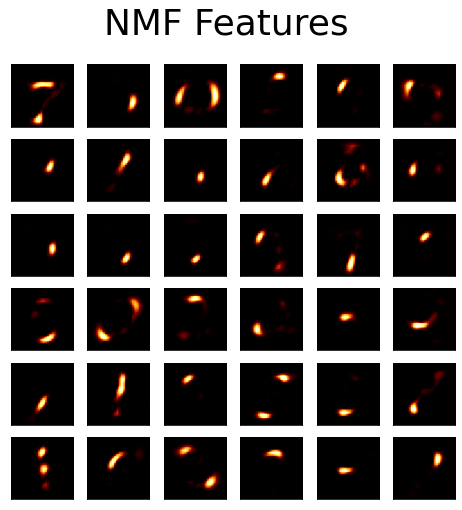

In [22]:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(Wnmf[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)
title = fig.suptitle('NMF Features', fontsize=36)

<h3>Problem 3: The Geometry of Handwritten Digits</h3>

In [23]:
data = np.load("../data/digits-labels.npz")

# Select columns of 6
images = data['d']
labels = data['l']
indexOfSixes = np.argwhere(labels == 6)
sixes = images[:, indexOfSixes].squeeze()
print(np.shape(sixes))

(784, 958)


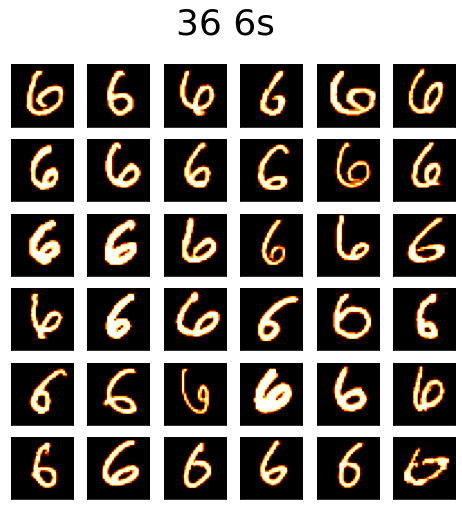

In [24]:
# plot some of the data to make sure we only have 6s:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(sixes[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)
title = fig.suptitle('36 6s', fontsize=36)

In [25]:
# Run PCA on the sixes and reduce the dimensions to 2 and find the projection of the data onto this space
Wp = pca(sixes, 2)
Zp = Wp @ sixes

In [26]:
# Run isomap on the 6's:
Zim = isomap(sixes.T).T

<h3>Figures for Problem 3:</h3>
<p>The next section contains the figures for the problem 3: </p>
<h5>PCA Manifold:</h5>
<p>
PCA does not learn anything about the manifold of the digit 6. The figure shows no real pattern in the geometry of the digits. There is no disernable pattern of the order of the 6's in this plot 
</p>
<h5>ISOMAP</h5>
<p>
When I run MDS using geodesic distances with 6 nearest neighbors (ISOMAP), there seems to be a pattern. The digits get more italic as I move from left to right in the plot (as annotated by the arrow in the figure). This is the manifold of 6's that the ISOMAP algorithm uncovered. This makes sense as ISOMAP tries to preserve local distances as best as it can while still reducing dimensions so we can visually inspect the geometry of our data.</p>

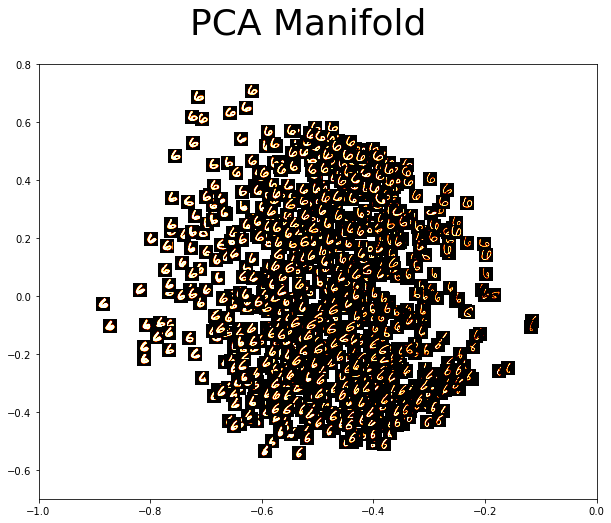

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot()
ax.set_xlim([-1,0])
ax.set_ylim([-.7,.8])
for i in range(958):
    six = sixes[:, i]
    image = np.reshape(six,(28,28),'F')
    coord = Zp[:, i]
    
    ab = AnnotationBbox(OffsetImage(image, zoom=0.5, cmap=plt.cm.afmhot), (coord[0], coord[1]), frameon=False)
    ax.add_artist(ab)
    
title = fig.suptitle('PCA Manifold', fontsize=36)

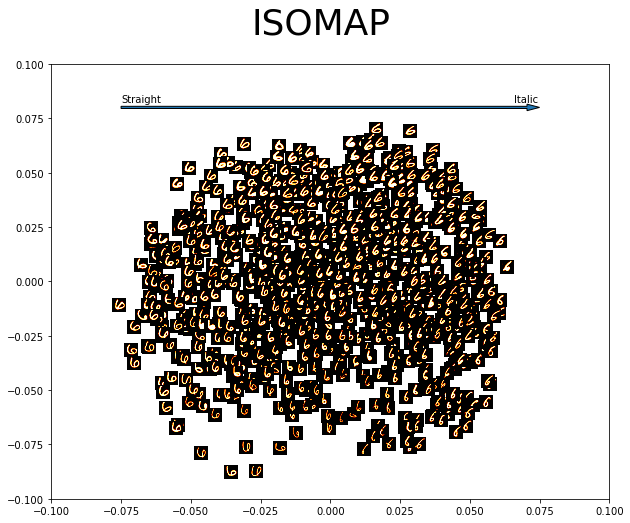

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot()
ax.set_xlim([-0.1,0.1])
ax.set_ylim([-.1,.1])
for i in range(958):
    six = sixes[:, i]
    image = np.reshape(six,(28,28),'F')
    coord = Zim[:, i]

    
    ab = AnnotationBbox(OffsetImage(image, zoom=0.5, cmap=plt.cm.afmhot), (coord[0], coord[1]), frameon=False)
    ax.add_artist(ab)
_ = plt.arrow(-0.075, 0.08, 0.15, 0, length_includes_head=True,)
_ = plt.text(-0.075, 0.0825, "Straight")
_ = plt.text(0.066, 0.0825, "Italic")
_ = fig.suptitle('ISOMAP', fontsize=36)